In [23]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [24]:
model_path = r''  # Insert path of the cpc model
dataset_path = r''  # Insert path of the test dataset that was created using the run_cpc.py script

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_64/models/epoch_25.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [25]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [26]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [27]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 20))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/15 [00:00<?, ?it/s]

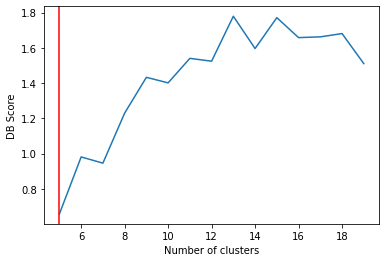

{0, 1, 2, 3, 4}


In [28]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

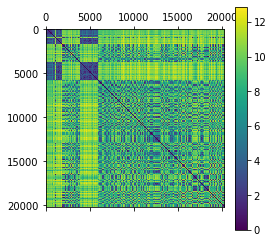

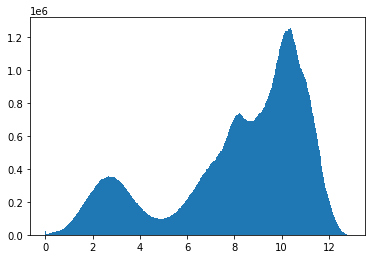

In [29]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

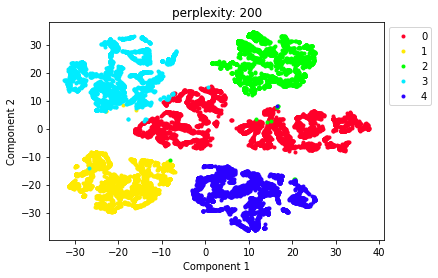

In [30]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [31]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [32]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [33]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [34]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 250
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 8

In [35]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.987434090573104


In [36]:
losses = []
accs = []
sparsity = []

In [37]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=2)
        

Average sparseness: 0.3218936193261836
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.7417127071823204
layer 3: 0.494475138121547
layer 4: 0.494475138121547
layer 5: 0.46357044198895025
layer 6: 0.35540400552486184
Epoch: 00 | Batch: 000 / 011 | Total loss: 1.609 | Reg loss: 0.014 | Tree loss: 1.609 | Accuracy: 0.185500 | 2.095 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 1.582 | Reg loss: 0.014 | Tree loss: 1.582 | Accuracy: 0.282500 | 1.179 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 1.559 | Reg loss: 0.013 | Tree loss: 1.559 | Accuracy: 0.470000 | 0.872 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 1.536 | Reg loss: 0.013 | Tree loss: 1.536 | Accuracy: 0.497500 | 0.719 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 1.517 | Reg loss: 0.013 | Tree loss: 1.517 | Accuracy: 0.459500 | 0.627 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 1.513 | Reg loss: 0.013 | Tree loss: 1.513 | Accuracy: 0.371500 | 0.561 sec/iter
Epoch: 00 | Batch: 006 

Epoch: 05 | Batch: 001 / 011 | Total loss: 1.517 | Reg loss: 0.011 | Tree loss: 1.517 | Accuracy: 0.552500 | 0.525 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 1.495 | Reg loss: 0.011 | Tree loss: 1.495 | Accuracy: 0.537000 | 0.52 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 1.465 | Reg loss: 0.012 | Tree loss: 1.465 | Accuracy: 0.546500 | 0.516 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 1.429 | Reg loss: 0.012 | Tree loss: 1.429 | Accuracy: 0.567000 | 0.512 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 1.415 | Reg loss: 0.012 | Tree loss: 1.415 | Accuracy: 0.541500 | 0.508 sec/iter
Epoch: 05 | Batch: 006 / 011 | Total loss: 1.386 | Reg loss: 0.012 | Tree loss: 1.386 | Accuracy: 0.544500 | 0.504 sec/iter
Epoch: 05 | Batch: 007 / 011 | Total loss: 1.375 | Reg loss: 0.013 | Tree loss: 1.375 | Accuracy: 0.533000 | 0.499 sec/iter
Epoch: 05 | Batch: 008 / 011 | Total loss: 1.355 | Reg loss: 0.013 | Tree loss: 1.355 | Accuracy: 0.530000 | 0.495 sec/iter
Epoch: 05

Epoch: 10 | Batch: 003 / 011 | Total loss: 1.339 | Reg loss: 0.014 | Tree loss: 1.339 | Accuracy: 0.607500 | 0.491 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 1.321 | Reg loss: 0.014 | Tree loss: 1.321 | Accuracy: 0.539500 | 0.489 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 1.267 | Reg loss: 0.014 | Tree loss: 1.267 | Accuracy: 0.564000 | 0.486 sec/iter
Epoch: 10 | Batch: 006 / 011 | Total loss: 1.226 | Reg loss: 0.014 | Tree loss: 1.226 | Accuracy: 0.589500 | 0.484 sec/iter
Epoch: 10 | Batch: 007 / 011 | Total loss: 1.206 | Reg loss: 0.015 | Tree loss: 1.206 | Accuracy: 0.575000 | 0.482 sec/iter
Epoch: 10 | Batch: 008 / 011 | Total loss: 1.174 | Reg loss: 0.015 | Tree loss: 1.174 | Accuracy: 0.594500 | 0.479 sec/iter
Epoch: 10 | Batch: 009 / 011 | Total loss: 1.159 | Reg loss: 0.015 | Tree loss: 1.159 | Accuracy: 0.595000 | 0.477 sec/iter
Epoch: 10 | Batch: 010 / 011 | Total loss: 1.123 | Reg loss: 0.016 | Tree loss: 1.123 | Accuracy: 0.590444 | 0.475 sec/iter
Average 

Epoch: 15 | Batch: 005 / 011 | Total loss: 1.114 | Reg loss: 0.016 | Tree loss: 1.114 | Accuracy: 0.714500 | 0.425 sec/iter
Epoch: 15 | Batch: 006 / 011 | Total loss: 1.088 | Reg loss: 0.017 | Tree loss: 1.088 | Accuracy: 0.688000 | 0.424 sec/iter
Epoch: 15 | Batch: 007 / 011 | Total loss: 1.036 | Reg loss: 0.017 | Tree loss: 1.036 | Accuracy: 0.689500 | 0.423 sec/iter
Epoch: 15 | Batch: 008 / 011 | Total loss: 1.030 | Reg loss: 0.017 | Tree loss: 1.030 | Accuracy: 0.654500 | 0.422 sec/iter
Epoch: 15 | Batch: 009 / 011 | Total loss: 0.997 | Reg loss: 0.017 | Tree loss: 0.997 | Accuracy: 0.657000 | 0.421 sec/iter
Epoch: 15 | Batch: 010 / 011 | Total loss: 1.000 | Reg loss: 0.018 | Tree loss: 1.000 | Accuracy: 0.610922 | 0.419 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 16 | Batch: 000 / 01

Epoch: 20 | Batch: 007 / 011 | Total loss: 0.907 | Reg loss: 0.019 | Tree loss: 0.907 | Accuracy: 0.762000 | 0.445 sec/iter
Epoch: 20 | Batch: 008 / 011 | Total loss: 0.903 | Reg loss: 0.019 | Tree loss: 0.903 | Accuracy: 0.716000 | 0.444 sec/iter
Epoch: 20 | Batch: 009 / 011 | Total loss: 0.883 | Reg loss: 0.019 | Tree loss: 0.883 | Accuracy: 0.699000 | 0.443 sec/iter
Epoch: 20 | Batch: 010 / 011 | Total loss: 0.863 | Reg loss: 0.019 | Tree loss: 0.863 | Accuracy: 0.655290 | 0.442 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 21 | Batch: 000 / 011 | Total loss: 1.235 | Reg loss: 0.018 | Tree loss: 1.235 | Accuracy: 0.814500 | 0.458 sec/iter
Epoch: 21 | Batch: 001 / 011 | Total loss: 1.167 | Reg loss: 0.018 | Tree loss: 1.167 | Accuracy: 0.806000 | 0.458 sec/iter
Epoch: 21 | Batch: 002 / 01

Epoch: 25 | Batch: 009 / 011 | Total loss: 0.771 | Reg loss: 0.021 | Tree loss: 0.771 | Accuracy: 0.747500 | 0.454 sec/iter
Epoch: 25 | Batch: 010 / 011 | Total loss: 0.802 | Reg loss: 0.021 | Tree loss: 0.802 | Accuracy: 0.737201 | 0.453 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 26 | Batch: 000 / 011 | Total loss: 1.129 | Reg loss: 0.020 | Tree loss: 1.129 | Accuracy: 0.779500 | 0.46 sec/iter
Epoch: 26 | Batch: 001 / 011 | Total loss: 1.078 | Reg loss: 0.020 | Tree loss: 1.078 | Accuracy: 0.771500 | 0.459 sec/iter
Epoch: 26 | Batch: 002 / 011 | Total loss: 1.017 | Reg loss: 0.020 | Tree loss: 1.017 | Accuracy: 0.773000 | 0.458 sec/iter
Epoch: 26 | Batch: 003 / 011 | Total loss: 0.950 | Reg loss: 0.020 | Tree loss: 0.950 | Accuracy: 0.779500 | 0.457 sec/iter
Epoch: 26 | Batch: 004 / 011

Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 31 | Batch: 000 / 011 | Total loss: 1.023 | Reg loss: 0.022 | Tree loss: 1.023 | Accuracy: 0.769000 | 0.473 sec/iter
Epoch: 31 | Batch: 001 / 011 | Total loss: 0.962 | Reg loss: 0.022 | Tree loss: 0.962 | Accuracy: 0.774500 | 0.472 sec/iter
Epoch: 31 | Batch: 002 / 011 | Total loss: 0.927 | Reg loss: 0.022 | Tree loss: 0.927 | Accuracy: 0.763500 | 0.471 sec/iter
Epoch: 31 | Batch: 003 / 011 | Total loss: 0.886 | Reg loss: 0.022 | Tree loss: 0.886 | Accuracy: 0.749500 | 0.471 sec/iter
Epoch: 31 | Batch: 004 / 011 | Total loss: 0.826 | Reg loss: 0.022 | Tree loss: 0.826 | Accuracy: 0.766000 | 0.47 sec/iter
Epoch: 31 | Batch: 005 / 011 | Total loss: 0.793 | Reg loss: 0.022 | Tree loss: 0.793 | Accuracy: 0.767000 | 0.469 sec/iter
Epoch: 31 | Batch: 006 / 011

Epoch: 36 | Batch: 001 / 011 | Total loss: 0.889 | Reg loss: 0.023 | Tree loss: 0.889 | Accuracy: 0.781500 | 0.472 sec/iter
Epoch: 36 | Batch: 002 / 011 | Total loss: 0.842 | Reg loss: 0.023 | Tree loss: 0.842 | Accuracy: 0.787500 | 0.471 sec/iter
Epoch: 36 | Batch: 003 / 011 | Total loss: 0.793 | Reg loss: 0.023 | Tree loss: 0.793 | Accuracy: 0.778000 | 0.471 sec/iter
Epoch: 36 | Batch: 004 / 011 | Total loss: 0.741 | Reg loss: 0.023 | Tree loss: 0.741 | Accuracy: 0.794000 | 0.47 sec/iter
Epoch: 36 | Batch: 005 / 011 | Total loss: 0.708 | Reg loss: 0.023 | Tree loss: 0.708 | Accuracy: 0.801000 | 0.47 sec/iter
Epoch: 36 | Batch: 006 / 011 | Total loss: 0.662 | Reg loss: 0.023 | Tree loss: 0.662 | Accuracy: 0.821000 | 0.469 sec/iter
Epoch: 36 | Batch: 007 / 011 | Total loss: 0.643 | Reg loss: 0.023 | Tree loss: 0.643 | Accuracy: 0.832000 | 0.469 sec/iter
Epoch: 36 | Batch: 008 / 011 | Total loss: 0.630 | Reg loss: 0.023 | Tree loss: 0.630 | Accuracy: 0.806000 | 0.468 sec/iter
Epoch: 36 

Epoch: 41 | Batch: 003 / 011 | Total loss: 0.743 | Reg loss: 0.024 | Tree loss: 0.743 | Accuracy: 0.786000 | 0.464 sec/iter
Epoch: 41 | Batch: 004 / 011 | Total loss: 0.707 | Reg loss: 0.024 | Tree loss: 0.707 | Accuracy: 0.790000 | 0.463 sec/iter
Epoch: 41 | Batch: 005 / 011 | Total loss: 0.680 | Reg loss: 0.024 | Tree loss: 0.680 | Accuracy: 0.783500 | 0.463 sec/iter
Epoch: 41 | Batch: 006 / 011 | Total loss: 0.648 | Reg loss: 0.024 | Tree loss: 0.648 | Accuracy: 0.784000 | 0.462 sec/iter
Epoch: 41 | Batch: 007 / 011 | Total loss: 0.603 | Reg loss: 0.024 | Tree loss: 0.603 | Accuracy: 0.829000 | 0.462 sec/iter
Epoch: 41 | Batch: 008 / 011 | Total loss: 0.576 | Reg loss: 0.024 | Tree loss: 0.576 | Accuracy: 0.847000 | 0.461 sec/iter
Epoch: 41 | Batch: 009 / 011 | Total loss: 0.587 | Reg loss: 0.025 | Tree loss: 0.587 | Accuracy: 0.831000 | 0.461 sec/iter
Epoch: 41 | Batch: 010 / 011 | Total loss: 0.579 | Reg loss: 0.025 | Tree loss: 0.579 | Accuracy: 0.805461 | 0.46 sec/iter
Average s

Epoch: 46 | Batch: 005 / 011 | Total loss: 0.632 | Reg loss: 0.025 | Tree loss: 0.632 | Accuracy: 0.788500 | 0.465 sec/iter
Epoch: 46 | Batch: 006 / 011 | Total loss: 0.609 | Reg loss: 0.025 | Tree loss: 0.609 | Accuracy: 0.813000 | 0.465 sec/iter
Epoch: 46 | Batch: 007 / 011 | Total loss: 0.585 | Reg loss: 0.025 | Tree loss: 0.585 | Accuracy: 0.833000 | 0.464 sec/iter
Epoch: 46 | Batch: 008 / 011 | Total loss: 0.540 | Reg loss: 0.025 | Tree loss: 0.540 | Accuracy: 0.846500 | 0.464 sec/iter
Epoch: 46 | Batch: 009 / 011 | Total loss: 0.547 | Reg loss: 0.025 | Tree loss: 0.547 | Accuracy: 0.835500 | 0.463 sec/iter
Epoch: 46 | Batch: 010 / 011 | Total loss: 0.516 | Reg loss: 0.025 | Tree loss: 0.516 | Accuracy: 0.836177 | 0.463 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 47 | Batch: 000 / 01

Epoch: 51 | Batch: 007 / 011 | Total loss: 0.531 | Reg loss: 0.026 | Tree loss: 0.531 | Accuracy: 0.855000 | 0.464 sec/iter
Epoch: 51 | Batch: 008 / 011 | Total loss: 0.533 | Reg loss: 0.026 | Tree loss: 0.533 | Accuracy: 0.852500 | 0.464 sec/iter
Epoch: 51 | Batch: 009 / 011 | Total loss: 0.536 | Reg loss: 0.026 | Tree loss: 0.536 | Accuracy: 0.837000 | 0.464 sec/iter
Epoch: 51 | Batch: 010 / 011 | Total loss: 0.533 | Reg loss: 0.026 | Tree loss: 0.533 | Accuracy: 0.839590 | 0.463 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 52 | Batch: 000 / 011 | Total loss: 0.782 | Reg loss: 0.026 | Tree loss: 0.782 | Accuracy: 0.741500 | 0.47 sec/iter
Epoch: 52 | Batch: 001 / 011 | Total loss: 0.758 | Reg loss: 0.026 | Tree loss: 0.758 | Accuracy: 0.734000 | 0.469 sec/iter
Epoch: 52 | Batch: 002 / 011

Epoch: 56 | Batch: 009 / 011 | Total loss: 0.511 | Reg loss: 0.027 | Tree loss: 0.511 | Accuracy: 0.844000 | 0.47 sec/iter
Epoch: 56 | Batch: 010 / 011 | Total loss: 0.510 | Reg loss: 0.027 | Tree loss: 0.510 | Accuracy: 0.819113 | 0.47 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 57 | Batch: 000 / 011 | Total loss: 0.764 | Reg loss: 0.027 | Tree loss: 0.764 | Accuracy: 0.753000 | 0.473 sec/iter
Epoch: 57 | Batch: 001 / 011 | Total loss: 0.705 | Reg loss: 0.027 | Tree loss: 0.705 | Accuracy: 0.765500 | 0.473 sec/iter
Epoch: 57 | Batch: 002 / 011 | Total loss: 0.679 | Reg loss: 0.027 | Tree loss: 0.679 | Accuracy: 0.767500 | 0.473 sec/iter
Epoch: 57 | Batch: 003 / 011 | Total loss: 0.634 | Reg loss: 0.027 | Tree loss: 0.634 | Accuracy: 0.788500 | 0.472 sec/iter
Epoch: 57 | Batch: 004 / 011 

Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 62 | Batch: 000 / 011 | Total loss: 0.754 | Reg loss: 0.027 | Tree loss: 0.754 | Accuracy: 0.741000 | 0.475 sec/iter
Epoch: 62 | Batch: 001 / 011 | Total loss: 0.686 | Reg loss: 0.027 | Tree loss: 0.686 | Accuracy: 0.770500 | 0.475 sec/iter
Epoch: 62 | Batch: 002 / 011 | Total loss: 0.667 | Reg loss: 0.027 | Tree loss: 0.667 | Accuracy: 0.781000 | 0.475 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 0.629 | Reg loss: 0.027 | Tree loss: 0.629 | Accuracy: 0.786000 | 0.474 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 0.591 | Reg loss: 0.027 | Tree loss: 0.591 | Accuracy: 0.801500 | 0.474 sec/iter
Epoch: 62 | Batch: 005 / 011 | Total loss: 0.560 | Reg loss: 0.027 | Tree loss: 0.560 | Accuracy: 0.813500 | 0.474 sec/iter
Epoch: 62 | Batch: 006 / 01

Epoch: 67 | Batch: 001 / 011 | Total loss: 0.685 | Reg loss: 0.028 | Tree loss: 0.685 | Accuracy: 0.757000 | 0.47 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 0.647 | Reg loss: 0.028 | Tree loss: 0.647 | Accuracy: 0.776000 | 0.47 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 0.610 | Reg loss: 0.028 | Tree loss: 0.610 | Accuracy: 0.784500 | 0.47 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 0.582 | Reg loss: 0.028 | Tree loss: 0.582 | Accuracy: 0.799500 | 0.469 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 0.526 | Reg loss: 0.028 | Tree loss: 0.526 | Accuracy: 0.837000 | 0.469 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 0.534 | Reg loss: 0.028 | Tree loss: 0.534 | Accuracy: 0.835000 | 0.469 sec/iter
Epoch: 67 | Batch: 007 / 011 | Total loss: 0.496 | Reg loss: 0.028 | Tree loss: 0.496 | Accuracy: 0.862000 | 0.468 sec/iter
Epoch: 67 | Batch: 008 / 011 | Total loss: 0.480 | Reg loss: 0.028 | Tree loss: 0.480 | Accuracy: 0.866000 | 0.468 sec/iter
Epoch: 67 |

Epoch: 72 | Batch: 003 / 011 | Total loss: 0.562 | Reg loss: 0.028 | Tree loss: 0.562 | Accuracy: 0.814000 | 0.463 sec/iter
Epoch: 72 | Batch: 004 / 011 | Total loss: 0.563 | Reg loss: 0.028 | Tree loss: 0.563 | Accuracy: 0.808500 | 0.462 sec/iter
Epoch: 72 | Batch: 005 / 011 | Total loss: 0.561 | Reg loss: 0.028 | Tree loss: 0.561 | Accuracy: 0.815500 | 0.462 sec/iter
Epoch: 72 | Batch: 006 / 011 | Total loss: 0.498 | Reg loss: 0.028 | Tree loss: 0.498 | Accuracy: 0.863500 | 0.462 sec/iter
Epoch: 72 | Batch: 007 / 011 | Total loss: 0.499 | Reg loss: 0.028 | Tree loss: 0.499 | Accuracy: 0.862000 | 0.462 sec/iter
Epoch: 72 | Batch: 008 / 011 | Total loss: 0.498 | Reg loss: 0.028 | Tree loss: 0.498 | Accuracy: 0.854000 | 0.461 sec/iter
Epoch: 72 | Batch: 009 / 011 | Total loss: 0.471 | Reg loss: 0.028 | Tree loss: 0.471 | Accuracy: 0.860500 | 0.461 sec/iter
Epoch: 72 | Batch: 010 / 011 | Total loss: 0.466 | Reg loss: 0.029 | Tree loss: 0.466 | Accuracy: 0.870307 | 0.461 sec/iter
Average 

Epoch: 77 | Batch: 005 / 011 | Total loss: 0.525 | Reg loss: 0.029 | Tree loss: 0.525 | Accuracy: 0.845000 | 0.464 sec/iter
Epoch: 77 | Batch: 006 / 011 | Total loss: 0.499 | Reg loss: 0.029 | Tree loss: 0.499 | Accuracy: 0.853000 | 0.464 sec/iter
Epoch: 77 | Batch: 007 / 011 | Total loss: 0.498 | Reg loss: 0.029 | Tree loss: 0.498 | Accuracy: 0.861500 | 0.464 sec/iter
Epoch: 77 | Batch: 008 / 011 | Total loss: 0.485 | Reg loss: 0.029 | Tree loss: 0.485 | Accuracy: 0.859500 | 0.463 sec/iter
Epoch: 77 | Batch: 009 / 011 | Total loss: 0.466 | Reg loss: 0.029 | Tree loss: 0.466 | Accuracy: 0.866500 | 0.463 sec/iter
Epoch: 77 | Batch: 010 / 011 | Total loss: 0.445 | Reg loss: 0.029 | Tree loss: 0.445 | Accuracy: 0.870307 | 0.463 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 78 | Batch: 000 / 01

Epoch: 82 | Batch: 007 / 011 | Total loss: 0.494 | Reg loss: 0.029 | Tree loss: 0.494 | Accuracy: 0.858500 | 0.468 sec/iter
Epoch: 82 | Batch: 008 / 011 | Total loss: 0.470 | Reg loss: 0.029 | Tree loss: 0.470 | Accuracy: 0.869000 | 0.468 sec/iter
Epoch: 82 | Batch: 009 / 011 | Total loss: 0.445 | Reg loss: 0.029 | Tree loss: 0.445 | Accuracy: 0.879000 | 0.467 sec/iter
Epoch: 82 | Batch: 010 / 011 | Total loss: 0.431 | Reg loss: 0.029 | Tree loss: 0.431 | Accuracy: 0.883959 | 0.467 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 83 | Batch: 000 / 011 | Total loss: 0.662 | Reg loss: 0.029 | Tree loss: 0.662 | Accuracy: 0.766000 | 0.471 sec/iter
Epoch: 83 | Batch: 001 / 011 | Total loss: 0.636 | Reg loss: 0.029 | Tree loss: 0.636 | Accuracy: 0.765500 | 0.471 sec/iter
Epoch: 83 | Batch: 002 / 01

Epoch: 87 | Batch: 009 / 011 | Total loss: 0.454 | Reg loss: 0.030 | Tree loss: 0.454 | Accuracy: 0.879500 | 0.467 sec/iter
Epoch: 87 | Batch: 010 / 011 | Total loss: 0.438 | Reg loss: 0.030 | Tree loss: 0.438 | Accuracy: 0.873720 | 0.467 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 88 | Batch: 000 / 011 | Total loss: 0.649 | Reg loss: 0.029 | Tree loss: 0.649 | Accuracy: 0.764000 | 0.469 sec/iter
Epoch: 88 | Batch: 001 / 011 | Total loss: 0.624 | Reg loss: 0.029 | Tree loss: 0.624 | Accuracy: 0.770000 | 0.469 sec/iter
Epoch: 88 | Batch: 002 / 011 | Total loss: 0.597 | Reg loss: 0.029 | Tree loss: 0.597 | Accuracy: 0.780000 | 0.469 sec/iter
Epoch: 88 | Batch: 003 / 011 | Total loss: 0.548 | Reg loss: 0.029 | Tree loss: 0.548 | Accuracy: 0.803000 | 0.469 sec/iter
Epoch: 88 | Batch: 004 / 01

Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 93 | Batch: 000 / 011 | Total loss: 0.631 | Reg loss: 0.030 | Tree loss: 0.631 | Accuracy: 0.772500 | 0.47 sec/iter
Epoch: 93 | Batch: 001 / 011 | Total loss: 0.616 | Reg loss: 0.030 | Tree loss: 0.616 | Accuracy: 0.776000 | 0.47 sec/iter
Epoch: 93 | Batch: 002 / 011 | Total loss: 0.569 | Reg loss: 0.030 | Tree loss: 0.569 | Accuracy: 0.800000 | 0.47 sec/iter
Epoch: 93 | Batch: 003 / 011 | Total loss: 0.543 | Reg loss: 0.030 | Tree loss: 0.543 | Accuracy: 0.799000 | 0.47 sec/iter
Epoch: 93 | Batch: 004 / 011 | Total loss: 0.506 | Reg loss: 0.030 | Tree loss: 0.506 | Accuracy: 0.837000 | 0.47 sec/iter
Epoch: 93 | Batch: 005 / 011 | Total loss: 0.508 | Reg loss: 0.030 | Tree loss: 0.508 | Accuracy: 0.854500 | 0.469 sec/iter
Epoch: 93 | Batch: 006 / 011 | T

Epoch: 98 | Batch: 001 / 011 | Total loss: 0.614 | Reg loss: 0.030 | Tree loss: 0.614 | Accuracy: 0.765500 | 0.463 sec/iter
Epoch: 98 | Batch: 002 / 011 | Total loss: 0.583 | Reg loss: 0.030 | Tree loss: 0.583 | Accuracy: 0.774000 | 0.463 sec/iter
Epoch: 98 | Batch: 003 / 011 | Total loss: 0.529 | Reg loss: 0.030 | Tree loss: 0.529 | Accuracy: 0.798000 | 0.463 sec/iter
Epoch: 98 | Batch: 004 / 011 | Total loss: 0.505 | Reg loss: 0.030 | Tree loss: 0.505 | Accuracy: 0.821500 | 0.463 sec/iter
Epoch: 98 | Batch: 005 / 011 | Total loss: 0.486 | Reg loss: 0.030 | Tree loss: 0.486 | Accuracy: 0.844000 | 0.462 sec/iter
Epoch: 98 | Batch: 006 / 011 | Total loss: 0.467 | Reg loss: 0.030 | Tree loss: 0.467 | Accuracy: 0.865000 | 0.462 sec/iter
Epoch: 98 | Batch: 007 / 011 | Total loss: 0.452 | Reg loss: 0.030 | Tree loss: 0.452 | Accuracy: 0.877000 | 0.462 sec/iter
Epoch: 98 | Batch: 008 / 011 | Total loss: 0.455 | Reg loss: 0.030 | Tree loss: 0.455 | Accuracy: 0.870500 | 0.462 sec/iter
Epoch: 9

Epoch: 103 | Batch: 003 / 011 | Total loss: 0.525 | Reg loss: 0.030 | Tree loss: 0.525 | Accuracy: 0.799500 | 0.464 sec/iter
Epoch: 103 | Batch: 004 / 011 | Total loss: 0.493 | Reg loss: 0.030 | Tree loss: 0.493 | Accuracy: 0.833500 | 0.463 sec/iter
Epoch: 103 | Batch: 005 / 011 | Total loss: 0.465 | Reg loss: 0.030 | Tree loss: 0.465 | Accuracy: 0.854000 | 0.463 sec/iter
Epoch: 103 | Batch: 006 / 011 | Total loss: 0.446 | Reg loss: 0.030 | Tree loss: 0.446 | Accuracy: 0.877000 | 0.463 sec/iter
Epoch: 103 | Batch: 007 / 011 | Total loss: 0.455 | Reg loss: 0.030 | Tree loss: 0.455 | Accuracy: 0.877500 | 0.463 sec/iter
Epoch: 103 | Batch: 008 / 011 | Total loss: 0.468 | Reg loss: 0.030 | Tree loss: 0.468 | Accuracy: 0.861000 | 0.462 sec/iter
Epoch: 103 | Batch: 009 / 011 | Total loss: 0.431 | Reg loss: 0.030 | Tree loss: 0.431 | Accuracy: 0.882500 | 0.462 sec/iter
Epoch: 103 | Batch: 010 / 011 | Total loss: 0.407 | Reg loss: 0.030 | Tree loss: 0.407 | Accuracy: 0.887372 | 0.462 sec/iter


Epoch: 108 | Batch: 005 / 011 | Total loss: 0.461 | Reg loss: 0.031 | Tree loss: 0.461 | Accuracy: 0.861000 | 0.467 sec/iter
Epoch: 108 | Batch: 006 / 011 | Total loss: 0.451 | Reg loss: 0.031 | Tree loss: 0.451 | Accuracy: 0.865500 | 0.467 sec/iter
Epoch: 108 | Batch: 007 / 011 | Total loss: 0.441 | Reg loss: 0.031 | Tree loss: 0.441 | Accuracy: 0.883000 | 0.467 sec/iter
Epoch: 108 | Batch: 008 / 011 | Total loss: 0.440 | Reg loss: 0.031 | Tree loss: 0.440 | Accuracy: 0.875000 | 0.466 sec/iter
Epoch: 108 | Batch: 009 / 011 | Total loss: 0.443 | Reg loss: 0.031 | Tree loss: 0.443 | Accuracy: 0.866500 | 0.466 sec/iter
Epoch: 108 | Batch: 010 / 011 | Total loss: 0.449 | Reg loss: 0.031 | Tree loss: 0.449 | Accuracy: 0.870307 | 0.466 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 109 | Batch: 0

Epoch: 113 | Batch: 007 / 011 | Total loss: 0.459 | Reg loss: 0.031 | Tree loss: 0.459 | Accuracy: 0.864000 | 0.468 sec/iter
Epoch: 113 | Batch: 008 / 011 | Total loss: 0.427 | Reg loss: 0.031 | Tree loss: 0.427 | Accuracy: 0.876500 | 0.468 sec/iter
Epoch: 113 | Batch: 009 / 011 | Total loss: 0.434 | Reg loss: 0.031 | Tree loss: 0.434 | Accuracy: 0.876500 | 0.468 sec/iter
Epoch: 113 | Batch: 010 / 011 | Total loss: 0.420 | Reg loss: 0.031 | Tree loss: 0.420 | Accuracy: 0.883959 | 0.468 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 114 | Batch: 000 / 011 | Total loss: 0.607 | Reg loss: 0.031 | Tree loss: 0.607 | Accuracy: 0.763000 | 0.469 sec/iter
Epoch: 114 | Batch: 001 / 011 | Total loss: 0.559 | Reg loss: 0.031 | Tree loss: 0.559 | Accuracy: 0.796500 | 0.469 sec/iter
Epoch: 114 | Batch: 0

Epoch: 118 | Batch: 009 / 011 | Total loss: 0.430 | Reg loss: 0.031 | Tree loss: 0.430 | Accuracy: 0.865500 | 0.47 sec/iter
Epoch: 118 | Batch: 010 / 011 | Total loss: 0.431 | Reg loss: 0.031 | Tree loss: 0.431 | Accuracy: 0.901024 | 0.47 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 119 | Batch: 000 / 011 | Total loss: 0.609 | Reg loss: 0.031 | Tree loss: 0.609 | Accuracy: 0.767000 | 0.472 sec/iter
Epoch: 119 | Batch: 001 / 011 | Total loss: 0.587 | Reg loss: 0.031 | Tree loss: 0.587 | Accuracy: 0.766500 | 0.472 sec/iter
Epoch: 119 | Batch: 002 / 011 | Total loss: 0.556 | Reg loss: 0.031 | Tree loss: 0.556 | Accuracy: 0.778000 | 0.472 sec/iter
Epoch: 119 | Batch: 003 / 011 | Total loss: 0.515 | Reg loss: 0.031 | Tree loss: 0.515 | Accuracy: 0.793000 | 0.472 sec/iter
Epoch: 119 | Batch: 004

Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 124 | Batch: 000 / 011 | Total loss: 0.611 | Reg loss: 0.031 | Tree loss: 0.611 | Accuracy: 0.763500 | 0.467 sec/iter
Epoch: 124 | Batch: 001 / 011 | Total loss: 0.594 | Reg loss: 0.031 | Tree loss: 0.594 | Accuracy: 0.767000 | 0.467 sec/iter
Epoch: 124 | Batch: 002 / 011 | Total loss: 0.547 | Reg loss: 0.031 | Tree loss: 0.547 | Accuracy: 0.788500 | 0.467 sec/iter
Epoch: 124 | Batch: 003 / 011 | Total loss: 0.513 | Reg loss: 0.031 | Tree loss: 0.513 | Accuracy: 0.805000 | 0.466 sec/iter
Epoch: 124 | Batch: 004 / 011 | Total loss: 0.479 | Reg loss: 0.031 | Tree loss: 0.479 | Accuracy: 0.836000 | 0.466 sec/iter
Epoch: 124 | Batch: 005 / 011 | Total loss: 0.438 | Reg loss: 0.031 | Tree loss: 0.438 | Accuracy: 0.876000 | 0.466 sec/iter
Epoch: 124 | Batch: 0

layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 129 | Batch: 000 / 011 | Total loss: 0.591 | Reg loss: 0.031 | Tree loss: 0.591 | Accuracy: 0.787000 | 0.467 sec/iter
Epoch: 129 | Batch: 001 / 011 | Total loss: 0.578 | Reg loss: 0.031 | Tree loss: 0.578 | Accuracy: 0.770500 | 0.467 sec/iter
Epoch: 129 | Batch: 002 / 011 | Total loss: 0.513 | Reg loss: 0.031 | Tree loss: 0.513 | Accuracy: 0.810500 | 0.467 sec/iter
Epoch: 129 | Batch: 003 / 011 | Total loss: 0.477 | Reg loss: 0.031 | Tree loss: 0.477 | Accuracy: 0.825000 | 0.467 sec/iter
Epoch: 129 | Batch: 004 / 011 | Total loss: 0.465 | Reg loss: 0.031 | Tree loss: 0.465 | Accuracy: 0.835000 | 0.467 sec/iter
Epoch: 129 | Batch: 005 / 011 | Total loss: 0.474 | Reg loss: 0.031 | Tree loss: 0.474 | Accuracy: 0.832500 | 0.466 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 0.431 | Reg loss: 0.031 | Tree loss: 0.431 | Accuracy: 0.863000 | 0.466 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 0.453 | Reg loss: 0.031 | 

Epoch: 134 | Batch: 001 / 011 | Total loss: 0.582 | Reg loss: 0.031 | Tree loss: 0.582 | Accuracy: 0.781000 | 0.467 sec/iter
Epoch: 134 | Batch: 002 / 011 | Total loss: 0.543 | Reg loss: 0.031 | Tree loss: 0.543 | Accuracy: 0.792500 | 0.467 sec/iter
Epoch: 134 | Batch: 003 / 011 | Total loss: 0.504 | Reg loss: 0.031 | Tree loss: 0.504 | Accuracy: 0.809500 | 0.467 sec/iter
Epoch: 134 | Batch: 004 / 011 | Total loss: 0.473 | Reg loss: 0.031 | Tree loss: 0.473 | Accuracy: 0.835500 | 0.467 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 0.449 | Reg loss: 0.031 | Tree loss: 0.449 | Accuracy: 0.855500 | 0.466 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 0.445 | Reg loss: 0.031 | Tree loss: 0.445 | Accuracy: 0.865000 | 0.466 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 0.441 | Reg loss: 0.031 | Tree loss: 0.441 | Accuracy: 0.866500 | 0.466 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 0.435 | Reg loss: 0.031 | Tree loss: 0.435 | Accuracy: 0.858000 | 0.466 sec/iter


Epoch: 139 | Batch: 003 / 011 | Total loss: 0.492 | Reg loss: 0.031 | Tree loss: 0.492 | Accuracy: 0.813000 | 0.469 sec/iter
Epoch: 139 | Batch: 004 / 011 | Total loss: 0.481 | Reg loss: 0.031 | Tree loss: 0.481 | Accuracy: 0.828000 | 0.469 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 0.443 | Reg loss: 0.031 | Tree loss: 0.443 | Accuracy: 0.851000 | 0.469 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 0.448 | Reg loss: 0.031 | Tree loss: 0.448 | Accuracy: 0.864500 | 0.469 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 0.464 | Reg loss: 0.031 | Tree loss: 0.464 | Accuracy: 0.850000 | 0.469 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 0.445 | Reg loss: 0.031 | Tree loss: 0.445 | Accuracy: 0.866000 | 0.469 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 0.437 | Reg loss: 0.031 | Tree loss: 0.437 | Accuracy: 0.865500 | 0.468 sec/iter
Epoch: 139 | Batch: 010 / 011 | Total loss: 0.411 | Reg loss: 0.031 | Tree loss: 0.411 | Accuracy: 0.883959 | 0.468 sec/iter


Epoch: 144 | Batch: 005 / 011 | Total loss: 0.465 | Reg loss: 0.031 | Tree loss: 0.465 | Accuracy: 0.838500 | 0.469 sec/iter
Epoch: 144 | Batch: 006 / 011 | Total loss: 0.442 | Reg loss: 0.031 | Tree loss: 0.442 | Accuracy: 0.846500 | 0.469 sec/iter
Epoch: 144 | Batch: 007 / 011 | Total loss: 0.439 | Reg loss: 0.031 | Tree loss: 0.439 | Accuracy: 0.863000 | 0.469 sec/iter
Epoch: 144 | Batch: 008 / 011 | Total loss: 0.443 | Reg loss: 0.031 | Tree loss: 0.443 | Accuracy: 0.856500 | 0.468 sec/iter
Epoch: 144 | Batch: 009 / 011 | Total loss: 0.425 | Reg loss: 0.031 | Tree loss: 0.425 | Accuracy: 0.867000 | 0.468 sec/iter
Epoch: 144 | Batch: 010 / 011 | Total loss: 0.369 | Reg loss: 0.031 | Tree loss: 0.369 | Accuracy: 0.924915 | 0.468 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 145 | Batch: 0

Epoch: 149 | Batch: 007 / 011 | Total loss: 0.445 | Reg loss: 0.031 | Tree loss: 0.445 | Accuracy: 0.866000 | 0.468 sec/iter
Epoch: 149 | Batch: 008 / 011 | Total loss: 0.436 | Reg loss: 0.031 | Tree loss: 0.436 | Accuracy: 0.856000 | 0.468 sec/iter
Epoch: 149 | Batch: 009 / 011 | Total loss: 0.424 | Reg loss: 0.031 | Tree loss: 0.424 | Accuracy: 0.863000 | 0.468 sec/iter
Epoch: 149 | Batch: 010 / 011 | Total loss: 0.398 | Reg loss: 0.031 | Tree loss: 0.398 | Accuracy: 0.873720 | 0.468 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 150 | Batch: 000 / 011 | Total loss: 0.599 | Reg loss: 0.031 | Tree loss: 0.599 | Accuracy: 0.773500 | 0.469 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 0.565 | Reg loss: 0.031 | Tree loss: 0.565 | Accuracy: 0.781500 | 0.469 sec/iter
Epoch: 150 | Batch: 0

Epoch: 154 | Batch: 009 / 011 | Total loss: 0.426 | Reg loss: 0.032 | Tree loss: 0.426 | Accuracy: 0.870000 | 0.462 sec/iter
Epoch: 154 | Batch: 010 / 011 | Total loss: 0.434 | Reg loss: 0.032 | Tree loss: 0.434 | Accuracy: 0.846416 | 0.462 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 155 | Batch: 000 / 011 | Total loss: 0.591 | Reg loss: 0.031 | Tree loss: 0.591 | Accuracy: 0.779000 | 0.464 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 0.592 | Reg loss: 0.031 | Tree loss: 0.592 | Accuracy: 0.763500 | 0.464 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 0.543 | Reg loss: 0.031 | Tree loss: 0.543 | Accuracy: 0.793000 | 0.464 sec/iter
Epoch: 155 | Batch: 003 / 011 | Total loss: 0.497 | Reg loss: 0.031 | Tree loss: 0.497 | Accuracy: 0.811000 | 0.464 sec/iter
Epoch: 155 | Batch: 0

Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 160 | Batch: 000 / 011 | Total loss: 0.580 | Reg loss: 0.031 | Tree loss: 0.580 | Accuracy: 0.785500 | 0.466 sec/iter
Epoch: 160 | Batch: 001 / 011 | Total loss: 0.570 | Reg loss: 0.031 | Tree loss: 0.570 | Accuracy: 0.779000 | 0.466 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 0.527 | Reg loss: 0.031 | Tree loss: 0.527 | Accuracy: 0.804000 | 0.466 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 0.498 | Reg loss: 0.031 | Tree loss: 0.498 | Accuracy: 0.817500 | 0.466 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 0.466 | Reg loss: 0.031 | Tree loss: 0.466 | Accuracy: 0.847500 | 0.466 sec/iter
Epoch: 160 | Batch: 005 / 011 | Total loss: 0.455 | Reg loss: 0.031 | Tree loss: 0.455 | Accuracy: 0.852500 | 0.465 sec/iter
Epoch: 160 | Batch: 0

layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 165 | Batch: 000 / 011 | Total loss: 0.577 | Reg loss: 0.032 | Tree loss: 0.577 | Accuracy: 0.782500 | 0.468 sec/iter
Epoch: 165 | Batch: 001 / 011 | Total loss: 0.571 | Reg loss: 0.032 | Tree loss: 0.571 | Accuracy: 0.781500 | 0.468 sec/iter
Epoch: 165 | Batch: 002 / 011 | Total loss: 0.559 | Reg loss: 0.032 | Tree loss: 0.559 | Accuracy: 0.790500 | 0.468 sec/iter
Epoch: 165 | Batch: 003 / 011 | Total loss: 0.505 | Reg loss: 0.032 | Tree loss: 0.505 | Accuracy: 0.814500 | 0.468 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 0.458 | Reg loss: 0.032 | Tree loss: 0.458 | Accuracy: 0.848000 | 0.468 sec/iter
Epoch: 165 | Batch: 005 / 011 | Total loss: 0.464 | Reg loss: 0.032 | Tree loss: 0.464 | Accuracy: 0.860500 | 0.468 sec/iter
Epoch: 165 | Batch: 006 / 011 | Total loss: 0.442 | Reg loss: 0.032 | Tree loss: 0.442 | Accuracy: 0.869500 | 0.468 sec/iter
Epoch: 165 | Batch: 007 / 011 | Total loss: 0.439 | Reg loss: 0.032 | 

Epoch: 170 | Batch: 001 / 011 | Total loss: 0.571 | Reg loss: 0.032 | Tree loss: 0.571 | Accuracy: 0.783000 | 0.468 sec/iter
Epoch: 170 | Batch: 002 / 011 | Total loss: 0.531 | Reg loss: 0.032 | Tree loss: 0.531 | Accuracy: 0.791500 | 0.468 sec/iter
Epoch: 170 | Batch: 003 / 011 | Total loss: 0.498 | Reg loss: 0.032 | Tree loss: 0.498 | Accuracy: 0.806500 | 0.468 sec/iter
Epoch: 170 | Batch: 004 / 011 | Total loss: 0.484 | Reg loss: 0.032 | Tree loss: 0.484 | Accuracy: 0.813500 | 0.468 sec/iter
Epoch: 170 | Batch: 005 / 011 | Total loss: 0.446 | Reg loss: 0.032 | Tree loss: 0.446 | Accuracy: 0.850000 | 0.468 sec/iter
Epoch: 170 | Batch: 006 / 011 | Total loss: 0.431 | Reg loss: 0.032 | Tree loss: 0.431 | Accuracy: 0.856000 | 0.468 sec/iter
Epoch: 170 | Batch: 007 / 011 | Total loss: 0.426 | Reg loss: 0.032 | Tree loss: 0.426 | Accuracy: 0.871500 | 0.468 sec/iter
Epoch: 170 | Batch: 008 / 011 | Total loss: 0.440 | Reg loss: 0.032 | Tree loss: 0.440 | Accuracy: 0.867000 | 0.467 sec/iter


Epoch: 175 | Batch: 003 / 011 | Total loss: 0.505 | Reg loss: 0.032 | Tree loss: 0.505 | Accuracy: 0.811000 | 0.468 sec/iter
Epoch: 175 | Batch: 004 / 011 | Total loss: 0.479 | Reg loss: 0.032 | Tree loss: 0.479 | Accuracy: 0.828000 | 0.468 sec/iter
Epoch: 175 | Batch: 005 / 011 | Total loss: 0.451 | Reg loss: 0.032 | Tree loss: 0.451 | Accuracy: 0.851500 | 0.467 sec/iter
Epoch: 175 | Batch: 006 / 011 | Total loss: 0.427 | Reg loss: 0.032 | Tree loss: 0.427 | Accuracy: 0.866000 | 0.467 sec/iter
Epoch: 175 | Batch: 007 / 011 | Total loss: 0.426 | Reg loss: 0.032 | Tree loss: 0.426 | Accuracy: 0.876500 | 0.467 sec/iter
Epoch: 175 | Batch: 008 / 011 | Total loss: 0.445 | Reg loss: 0.032 | Tree loss: 0.445 | Accuracy: 0.849000 | 0.467 sec/iter
Epoch: 175 | Batch: 009 / 011 | Total loss: 0.426 | Reg loss: 0.032 | Tree loss: 0.426 | Accuracy: 0.868000 | 0.467 sec/iter
Epoch: 175 | Batch: 010 / 011 | Total loss: 0.466 | Reg loss: 0.032 | Tree loss: 0.466 | Accuracy: 0.839590 | 0.467 sec/iter


Epoch: 180 | Batch: 005 / 011 | Total loss: 0.459 | Reg loss: 0.032 | Tree loss: 0.459 | Accuracy: 0.847000 | 0.466 sec/iter
Epoch: 180 | Batch: 006 / 011 | Total loss: 0.436 | Reg loss: 0.032 | Tree loss: 0.436 | Accuracy: 0.857000 | 0.466 sec/iter
Epoch: 180 | Batch: 007 / 011 | Total loss: 0.440 | Reg loss: 0.032 | Tree loss: 0.440 | Accuracy: 0.862500 | 0.466 sec/iter
Epoch: 180 | Batch: 008 / 011 | Total loss: 0.429 | Reg loss: 0.032 | Tree loss: 0.429 | Accuracy: 0.877000 | 0.465 sec/iter
Epoch: 180 | Batch: 009 / 011 | Total loss: 0.439 | Reg loss: 0.032 | Tree loss: 0.439 | Accuracy: 0.852000 | 0.465 sec/iter
Epoch: 180 | Batch: 010 / 011 | Total loss: 0.464 | Reg loss: 0.032 | Tree loss: 0.464 | Accuracy: 0.863481 | 0.465 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 181 | Batch: 0

Epoch: 185 | Batch: 007 / 011 | Total loss: 0.423 | Reg loss: 0.032 | Tree loss: 0.423 | Accuracy: 0.875000 | 0.466 sec/iter
Epoch: 185 | Batch: 008 / 011 | Total loss: 0.453 | Reg loss: 0.032 | Tree loss: 0.453 | Accuracy: 0.855500 | 0.466 sec/iter
Epoch: 185 | Batch: 009 / 011 | Total loss: 0.431 | Reg loss: 0.032 | Tree loss: 0.431 | Accuracy: 0.859500 | 0.466 sec/iter
Epoch: 185 | Batch: 010 / 011 | Total loss: 0.378 | Reg loss: 0.032 | Tree loss: 0.378 | Accuracy: 0.877133 | 0.466 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 186 | Batch: 000 / 011 | Total loss: 0.582 | Reg loss: 0.032 | Tree loss: 0.582 | Accuracy: 0.776500 | 0.467 sec/iter
Epoch: 186 | Batch: 001 / 011 | Total loss: 0.556 | Reg loss: 0.032 | Tree loss: 0.556 | Accuracy: 0.790500 | 0.467 sec/iter
Epoch: 186 | Batch: 0

Epoch: 190 | Batch: 009 / 011 | Total loss: 0.428 | Reg loss: 0.032 | Tree loss: 0.428 | Accuracy: 0.856500 | 0.466 sec/iter
Epoch: 190 | Batch: 010 / 011 | Total loss: 0.392 | Reg loss: 0.032 | Tree loss: 0.392 | Accuracy: 0.856655 | 0.466 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 191 | Batch: 000 / 011 | Total loss: 0.600 | Reg loss: 0.032 | Tree loss: 0.600 | Accuracy: 0.780500 | 0.468 sec/iter
Epoch: 191 | Batch: 001 / 011 | Total loss: 0.581 | Reg loss: 0.032 | Tree loss: 0.581 | Accuracy: 0.780500 | 0.468 sec/iter
Epoch: 191 | Batch: 002 / 011 | Total loss: 0.517 | Reg loss: 0.032 | Tree loss: 0.517 | Accuracy: 0.811500 | 0.467 sec/iter
Epoch: 191 | Batch: 003 / 011 | Total loss: 0.499 | Reg loss: 0.032 | Tree loss: 0.499 | Accuracy: 0.812500 | 0.467 sec/iter
Epoch: 191 | Batch: 0

Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 196 | Batch: 000 / 011 | Total loss: 0.577 | Reg loss: 0.032 | Tree loss: 0.577 | Accuracy: 0.780000 | 0.469 sec/iter
Epoch: 196 | Batch: 001 / 011 | Total loss: 0.564 | Reg loss: 0.032 | Tree loss: 0.564 | Accuracy: 0.790000 | 0.469 sec/iter
Epoch: 196 | Batch: 002 / 011 | Total loss: 0.528 | Reg loss: 0.032 | Tree loss: 0.528 | Accuracy: 0.812000 | 0.469 sec/iter
Epoch: 196 | Batch: 003 / 011 | Total loss: 0.507 | Reg loss: 0.032 | Tree loss: 0.507 | Accuracy: 0.815500 | 0.468 sec/iter
Epoch: 196 | Batch: 004 / 011 | Total loss: 0.471 | Reg loss: 0.032 | Tree loss: 0.471 | Accuracy: 0.843000 | 0.468 sec/iter
Epoch: 196 | Batch: 005 / 011 | Total loss: 0.459 | Reg loss: 0.032 | Tree loss: 0.459 | Accuracy: 0.854000 | 0.468 sec/iter
Epoch: 196 | Batch: 0

Epoch: 201 | Batch: 000 / 011 | Total loss: 0.560 | Reg loss: 0.032 | Tree loss: 0.560 | Accuracy: 0.799000 | 0.47 sec/iter
Epoch: 201 | Batch: 001 / 011 | Total loss: 0.565 | Reg loss: 0.032 | Tree loss: 0.565 | Accuracy: 0.792000 | 0.47 sec/iter
Epoch: 201 | Batch: 002 / 011 | Total loss: 0.543 | Reg loss: 0.032 | Tree loss: 0.543 | Accuracy: 0.783500 | 0.47 sec/iter
Epoch: 201 | Batch: 003 / 011 | Total loss: 0.500 | Reg loss: 0.032 | Tree loss: 0.500 | Accuracy: 0.807500 | 0.469 sec/iter
Epoch: 201 | Batch: 004 / 011 | Total loss: 0.474 | Reg loss: 0.032 | Tree loss: 0.474 | Accuracy: 0.825500 | 0.469 sec/iter
Epoch: 201 | Batch: 005 / 011 | Total loss: 0.452 | Reg loss: 0.032 | Tree loss: 0.452 | Accuracy: 0.844000 | 0.469 sec/iter
Epoch: 201 | Batch: 006 / 011 | Total loss: 0.413 | Reg loss: 0.032 | Tree loss: 0.413 | Accuracy: 0.874500 | 0.469 sec/iter
Epoch: 201 | Batch: 007 / 011 | Total loss: 0.452 | Reg loss: 0.032 | Tree loss: 0.452 | Accuracy: 0.865500 | 0.469 sec/iter
Epo

Epoch: 206 | Batch: 002 / 011 | Total loss: 0.534 | Reg loss: 0.032 | Tree loss: 0.534 | Accuracy: 0.799000 | 0.469 sec/iter
Epoch: 206 | Batch: 003 / 011 | Total loss: 0.498 | Reg loss: 0.032 | Tree loss: 0.498 | Accuracy: 0.811000 | 0.469 sec/iter
Epoch: 206 | Batch: 004 / 011 | Total loss: 0.480 | Reg loss: 0.032 | Tree loss: 0.480 | Accuracy: 0.818000 | 0.469 sec/iter
Epoch: 206 | Batch: 005 / 011 | Total loss: 0.452 | Reg loss: 0.032 | Tree loss: 0.452 | Accuracy: 0.837000 | 0.468 sec/iter
Epoch: 206 | Batch: 006 / 011 | Total loss: 0.412 | Reg loss: 0.032 | Tree loss: 0.412 | Accuracy: 0.886000 | 0.468 sec/iter
Epoch: 206 | Batch: 007 / 011 | Total loss: 0.436 | Reg loss: 0.032 | Tree loss: 0.436 | Accuracy: 0.862000 | 0.468 sec/iter
Epoch: 206 | Batch: 008 / 011 | Total loss: 0.437 | Reg loss: 0.032 | Tree loss: 0.437 | Accuracy: 0.866500 | 0.468 sec/iter
Epoch: 206 | Batch: 009 / 011 | Total loss: 0.410 | Reg loss: 0.032 | Tree loss: 0.410 | Accuracy: 0.872000 | 0.468 sec/iter


Epoch: 211 | Batch: 004 / 011 | Total loss: 0.468 | Reg loss: 0.032 | Tree loss: 0.468 | Accuracy: 0.830500 | 0.469 sec/iter
Epoch: 211 | Batch: 005 / 011 | Total loss: 0.443 | Reg loss: 0.032 | Tree loss: 0.443 | Accuracy: 0.852500 | 0.469 sec/iter
Epoch: 211 | Batch: 006 / 011 | Total loss: 0.435 | Reg loss: 0.032 | Tree loss: 0.435 | Accuracy: 0.866000 | 0.469 sec/iter
Epoch: 211 | Batch: 007 / 011 | Total loss: 0.442 | Reg loss: 0.032 | Tree loss: 0.442 | Accuracy: 0.853500 | 0.468 sec/iter
Epoch: 211 | Batch: 008 / 011 | Total loss: 0.431 | Reg loss: 0.032 | Tree loss: 0.431 | Accuracy: 0.870500 | 0.468 sec/iter
Epoch: 211 | Batch: 009 / 011 | Total loss: 0.421 | Reg loss: 0.032 | Tree loss: 0.421 | Accuracy: 0.859000 | 0.468 sec/iter
Epoch: 211 | Batch: 010 / 011 | Total loss: 0.423 | Reg loss: 0.032 | Tree loss: 0.423 | Accuracy: 0.856655 | 0.468 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer

Epoch: 216 | Batch: 006 / 011 | Total loss: 0.429 | Reg loss: 0.032 | Tree loss: 0.429 | Accuracy: 0.860000 | 0.469 sec/iter
Epoch: 216 | Batch: 007 / 011 | Total loss: 0.433 | Reg loss: 0.032 | Tree loss: 0.433 | Accuracy: 0.862500 | 0.469 sec/iter
Epoch: 216 | Batch: 008 / 011 | Total loss: 0.407 | Reg loss: 0.032 | Tree loss: 0.407 | Accuracy: 0.881000 | 0.468 sec/iter
Epoch: 216 | Batch: 009 / 011 | Total loss: 0.450 | Reg loss: 0.032 | Tree loss: 0.450 | Accuracy: 0.856000 | 0.468 sec/iter
Epoch: 216 | Batch: 010 / 011 | Total loss: 0.451 | Reg loss: 0.032 | Tree loss: 0.451 | Accuracy: 0.832765 | 0.468 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 217 | Batch: 000 / 011 | Total loss: 0.579 | Reg loss: 0.032 | Tree loss: 0.579 | Accuracy: 0.781000 | 0.47 sec/iter
Epoch: 217 | Batch: 00

Epoch: 221 | Batch: 008 / 011 | Total loss: 0.418 | Reg loss: 0.032 | Tree loss: 0.418 | Accuracy: 0.870500 | 0.47 sec/iter
Epoch: 221 | Batch: 009 / 011 | Total loss: 0.420 | Reg loss: 0.032 | Tree loss: 0.420 | Accuracy: 0.871500 | 0.47 sec/iter
Epoch: 221 | Batch: 010 / 011 | Total loss: 0.344 | Reg loss: 0.032 | Tree loss: 0.344 | Accuracy: 0.901024 | 0.47 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 222 | Batch: 000 / 011 | Total loss: 0.572 | Reg loss: 0.032 | Tree loss: 0.572 | Accuracy: 0.791500 | 0.471 sec/iter
Epoch: 222 | Batch: 001 / 011 | Total loss: 0.565 | Reg loss: 0.032 | Tree loss: 0.565 | Accuracy: 0.792000 | 0.471 sec/iter
Epoch: 222 | Batch: 002 / 011 | Total loss: 0.538 | Reg loss: 0.032 | Tree loss: 0.538 | Accuracy: 0.798000 | 0.471 sec/iter
Epoch: 222 | Batch: 003 

Epoch: 226 | Batch: 010 / 011 | Total loss: 0.420 | Reg loss: 0.032 | Tree loss: 0.420 | Accuracy: 0.863481 | 0.47 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 227 | Batch: 000 / 011 | Total loss: 0.560 | Reg loss: 0.032 | Tree loss: 0.560 | Accuracy: 0.811500 | 0.472 sec/iter
Epoch: 227 | Batch: 001 / 011 | Total loss: 0.567 | Reg loss: 0.032 | Tree loss: 0.567 | Accuracy: 0.794500 | 0.472 sec/iter
Epoch: 227 | Batch: 002 / 011 | Total loss: 0.522 | Reg loss: 0.032 | Tree loss: 0.522 | Accuracy: 0.807000 | 0.471 sec/iter
Epoch: 227 | Batch: 003 / 011 | Total loss: 0.490 | Reg loss: 0.032 | Tree loss: 0.490 | Accuracy: 0.818000 | 0.471 sec/iter
Epoch: 227 | Batch: 004 / 011 | Total loss: 0.452 | Reg loss: 0.032 | Tree loss: 0.452 | Accuracy: 0.838500 | 0.471 sec/iter
Epoch: 227 | Batch: 00

Epoch: 232 | Batch: 000 / 011 | Total loss: 0.589 | Reg loss: 0.032 | Tree loss: 0.589 | Accuracy: 0.795000 | 0.471 sec/iter
Epoch: 232 | Batch: 001 / 011 | Total loss: 0.561 | Reg loss: 0.032 | Tree loss: 0.561 | Accuracy: 0.792000 | 0.471 sec/iter
Epoch: 232 | Batch: 002 / 011 | Total loss: 0.539 | Reg loss: 0.032 | Tree loss: 0.539 | Accuracy: 0.799000 | 0.471 sec/iter
Epoch: 232 | Batch: 003 / 011 | Total loss: 0.480 | Reg loss: 0.032 | Tree loss: 0.480 | Accuracy: 0.833000 | 0.471 sec/iter
Epoch: 232 | Batch: 004 / 011 | Total loss: 0.455 | Reg loss: 0.032 | Tree loss: 0.455 | Accuracy: 0.839500 | 0.47 sec/iter
Epoch: 232 | Batch: 005 / 011 | Total loss: 0.431 | Reg loss: 0.032 | Tree loss: 0.431 | Accuracy: 0.860500 | 0.47 sec/iter
Epoch: 232 | Batch: 006 / 011 | Total loss: 0.396 | Reg loss: 0.032 | Tree loss: 0.396 | Accuracy: 0.884500 | 0.47 sec/iter
Epoch: 232 | Batch: 007 / 011 | Total loss: 0.421 | Reg loss: 0.032 | Tree loss: 0.421 | Accuracy: 0.877000 | 0.47 sec/iter
Epoc

Epoch: 237 | Batch: 002 / 011 | Total loss: 0.528 | Reg loss: 0.032 | Tree loss: 0.528 | Accuracy: 0.804500 | 0.471 sec/iter
Epoch: 237 | Batch: 003 / 011 | Total loss: 0.498 | Reg loss: 0.032 | Tree loss: 0.498 | Accuracy: 0.814500 | 0.471 sec/iter
Epoch: 237 | Batch: 004 / 011 | Total loss: 0.446 | Reg loss: 0.032 | Tree loss: 0.446 | Accuracy: 0.849500 | 0.471 sec/iter
Epoch: 237 | Batch: 005 / 011 | Total loss: 0.448 | Reg loss: 0.032 | Tree loss: 0.448 | Accuracy: 0.854500 | 0.471 sec/iter
Epoch: 237 | Batch: 006 / 011 | Total loss: 0.424 | Reg loss: 0.032 | Tree loss: 0.424 | Accuracy: 0.867500 | 0.471 sec/iter
Epoch: 237 | Batch: 007 / 011 | Total loss: 0.410 | Reg loss: 0.032 | Tree loss: 0.410 | Accuracy: 0.877000 | 0.47 sec/iter
Epoch: 237 | Batch: 008 / 011 | Total loss: 0.420 | Reg loss: 0.032 | Tree loss: 0.420 | Accuracy: 0.871000 | 0.47 sec/iter
Epoch: 237 | Batch: 009 / 011 | Total loss: 0.427 | Reg loss: 0.032 | Tree loss: 0.427 | Accuracy: 0.874000 | 0.47 sec/iter
Epo

Epoch: 242 | Batch: 004 / 011 | Total loss: 0.454 | Reg loss: 0.032 | Tree loss: 0.454 | Accuracy: 0.850500 | 0.471 sec/iter
Epoch: 242 | Batch: 005 / 011 | Total loss: 0.445 | Reg loss: 0.032 | Tree loss: 0.445 | Accuracy: 0.864500 | 0.471 sec/iter
Epoch: 242 | Batch: 006 / 011 | Total loss: 0.420 | Reg loss: 0.032 | Tree loss: 0.420 | Accuracy: 0.877000 | 0.471 sec/iter
Epoch: 242 | Batch: 007 / 011 | Total loss: 0.434 | Reg loss: 0.032 | Tree loss: 0.434 | Accuracy: 0.869000 | 0.47 sec/iter
Epoch: 242 | Batch: 008 / 011 | Total loss: 0.421 | Reg loss: 0.032 | Tree loss: 0.421 | Accuracy: 0.872500 | 0.47 sec/iter
Epoch: 242 | Batch: 009 / 011 | Total loss: 0.421 | Reg loss: 0.032 | Tree loss: 0.421 | Accuracy: 0.876500 | 0.47 sec/iter
Epoch: 242 | Batch: 010 / 011 | Total loss: 0.414 | Reg loss: 0.032 | Tree loss: 0.414 | Accuracy: 0.883959 | 0.47 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 

Epoch: 247 | Batch: 006 / 011 | Total loss: 0.428 | Reg loss: 0.032 | Tree loss: 0.428 | Accuracy: 0.872500 | 0.472 sec/iter
Epoch: 247 | Batch: 007 / 011 | Total loss: 0.439 | Reg loss: 0.032 | Tree loss: 0.439 | Accuracy: 0.865000 | 0.472 sec/iter
Epoch: 247 | Batch: 008 / 011 | Total loss: 0.413 | Reg loss: 0.032 | Tree loss: 0.413 | Accuracy: 0.875500 | 0.472 sec/iter
Epoch: 247 | Batch: 009 / 011 | Total loss: 0.428 | Reg loss: 0.032 | Tree loss: 0.428 | Accuracy: 0.876000 | 0.472 sec/iter
Epoch: 247 | Batch: 010 / 011 | Total loss: 0.386 | Reg loss: 0.032 | Tree loss: 0.386 | Accuracy: 0.901024 | 0.472 sec/iter
Average sparseness: 0.9889502762430937
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.988950276243094
layer 6: 0.9889502762430941
Epoch: 248 | Batch: 000 / 011 | Total loss: 0.554 | Reg loss: 0.032 | Tree loss: 0.554 | Accuracy: 0.803000 | 0.472 sec/iter
Epoch: 248 | Batch: 0

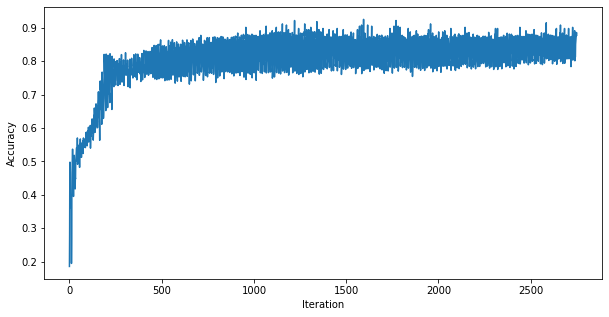

In [38]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

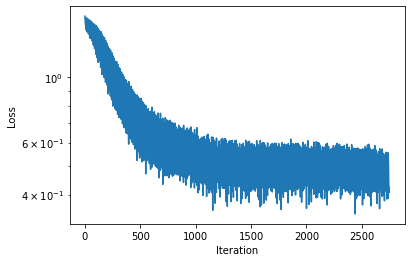

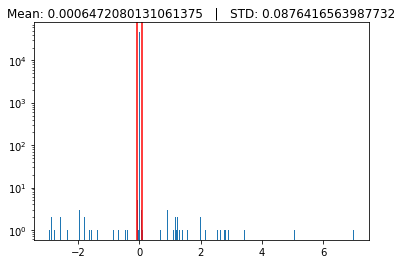

In [39]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 6.595238095238095


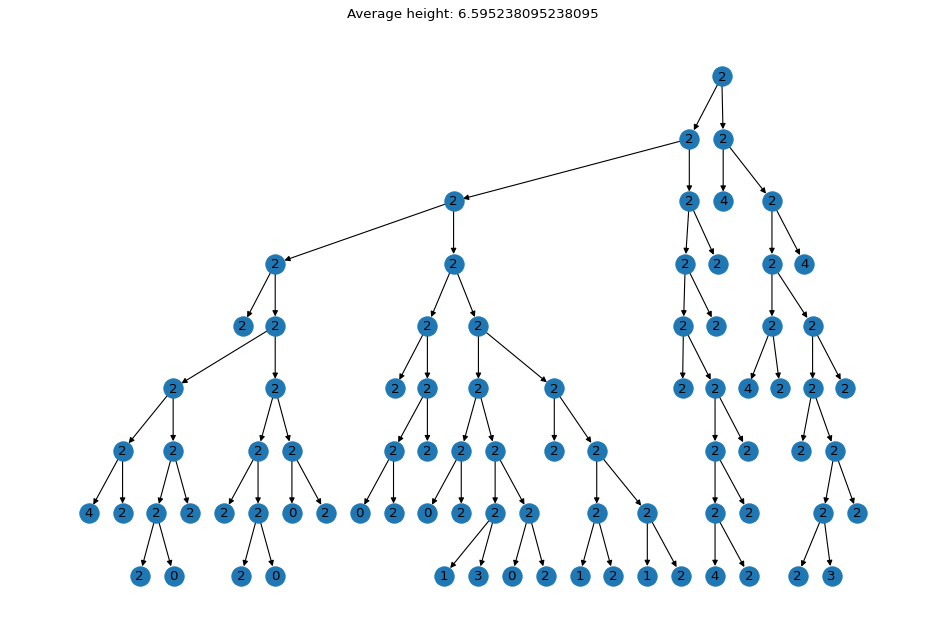

In [40]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [41]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 42


In [42]:
method = 'MLE'

In [43]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [44]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 1 ==============
359
============== Pattern 2 ==============
============== Pattern 3 ==============
800
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
16494
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
1
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
=========